In [1]:
import numpy as np
import pandas as pd
import splat
import popsims
from astropy.coordinates import SkyCoord, Galactic
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#sns.set_style("darkgrid", {"axes.facecolor": ".95"})

plt.style.use('fivethirtyeight')
plt.style.use('dark_background')

from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
from tqdm import tqdm
import matplotlib as mpl 
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] =20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['figure.titlesize'] = 20

splat.initializeStandards(all=True)

%matplotlib inline

Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database


In [2]:
0.5*(u.degree**2).to(u.arcmin**2)

1800.0000000000002

In [3]:
popsims.DATA_FOLDER

'/volumes/LaCie/wispsdata/db/'

In [4]:
#get evolutionary models
m='baraffe2003' #la base
thin_disk=popsims.make_systems(model_name=m, recompute=True, range=[0.01, 0.1, 0., 8.0],\
                              nsample=5e4)
thick_disk=popsims.make_systems(model_name=m, recompute=True, range=[0.01, 0.1, 8, 14.0],\
    nsample=5e5, filename='/users/caganze/research/popsims/data/{}_thick.pkl'.format(m))
halo=popsims.make_systems(model_name='roman2020', range=[0.01, 0.2, 10, 13.5 ],
                             recompute=True, nsample=5e5)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


[(0.005, 0.4)]

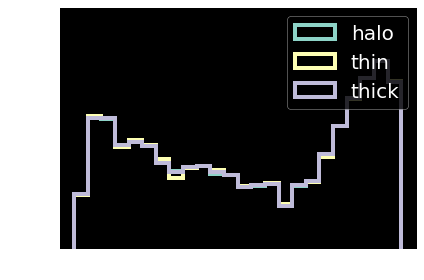

In [5]:
#compare the distributions visually
fig, ax=plt.subplots()
h=plt.hist(halo['spt'], bins=24, histtype='step', range=[15, 40], \
           log=True, density=True, label='halo', lw=4)
h=plt.hist(thin_disk['spt'],bins=24, histtype='step', range=[15, 40], \
           log=True, density=True, label='thin', lw=4)
h=plt.hist(thick_disk['spt'], bins=24, histtype='step', range=[15, 40], \
           log=True, density=True, label='thick', lw=4)
plt.tight_layout()
plt.legend()
ax.grid(False)
ax.set(ylim=[5e-3, 4e-1])

In [6]:
#halo

In [7]:
H=350
FOV={'jswt':220*(u.arcmin**2)*124,
    'GRS':  0.28*(u.deg**2),
    'PRS':0.28*(u.deg**2),
    'WFIRST_WIDE':2000*(u.deg**2),
    'EUCLID': 40*(u.deg**2)}

#make magnitude cuts
grism_cuts={'JSWT':{'NIRCAM_F200W':[1, 27.2], 'NIRCAM_F115W':[1, 27.2]},
              'GRS':{'WFIRST_WFIJ':[1, 20.8]},
            'PRS':{'WFIRST_WFIJ':[1, 23.5]},
            'WFIRST_WIDE':{'WFIRST_WFIJ': [1,24.], 'WFIRST_WFIH':[1,24.]},
           'EUCLID':{'EUCLID_J':[1., 27.]}}

#the goods north field
#POINTS={'}
POINTS={'wfirst':SkyCoord(l=-30.0*u.deg, b=-30*u.deg, frame='galactic'),
        'euclid':SkyCoord(l=24.6*u.deg, b=-82.0*u.deg , frame='galactic'),
        'lsst':SkyCoord(l=224.07*u.deg, b=-54.47*u.deg, frame='galactic'),
        'jswt':SkyCoord(ra="12:06:55", dec="62:14:15", unit=(u.hourangle, u.deg)),
        'spherex':SkyCoord(l=224.07*u.deg, b=-54.47*u.deg, frame='galactic')}

In [8]:
#local luminosity function
#LF=pd.read_pickle(popsims.DATA_FOLDER+'/lf_scales.pkl')

In [9]:
def scale_to_lf(data):
    scale=data.scale.iloc[0]
    return scale
        

def make_cuts(df,  cut_dict, survey='JSWT'):
    dcts=grism_cuts[survey]
    return df[np.logical_and.reduce([df[k]< dcts[k][1] for k in dcts.keys()])]

def get_average_distance_limits(p, cut_dict, survey='JSWT'):
    p.mag_limits=grism_cuts[survey.upper()]
    return dict(pd.DataFrame(p.distance_limits).applymap(lambda x: x[1]).median(axis=1))

In [10]:
#popsims.create_population?

In [11]:
#fov

In [12]:
def get_numbers(coord, fov, cuts, **kwargs):
    NCOUNTS={}
    spgrid=kwargs.get('spgrid', [20, 30])
    h=kwargs.get('h', 350)
    kind=kwargs.get('kind', 'disk')
    survey=kwargs.get('survey', 'survey')
    model=kwargs.get('model', 'burrows1997')
    mag_keys=kwargs.get('mag_keys', [])
    volume_kind='exp'
    
    if kind!='disk':
        volume_kind='spheroid'
    
    p=popsims.Pointing(coord=coord)
    dists=p.draw_distances(1, 5000, h=h, nsample=1e5)
    dff=popsims.create_pop(bfraction=0.2,\
                         model= model,\
                             l=p.coord.galactic.l.radian,\
                           b=p.coord.galactic.b.radian,\
                           absmag_keys=mag_keys, \
                           nsample=1e6,
                           distances=dists,
                  poptype='dwarfs')
    print (dff.columns)
    scale=np.nanmedian(dff.scale)
    df_cut= make_cuts(dff,cuts, survey=survey)
    dct= get_average_distance_limits(p, cuts, survey=survey)
    nxbr_counts=[]
    vols=[]
    for spt in tqdm(spgrid):
        sptvol=popsims.volume_calc(p.coord.galactic.l.radian,\
                                   p.coord.galactic.b.radian,
                                   1., dct[spt], h, kind=volume_kind)*(fov.to(u.radian**2)).value
        df_select= df_cut[np.logical_and(df_cut.spt>=spt, df_cut.spt<spt+0.99)]


        nbrs=len(df_select)
        cnbrs=nbrs*sptvol*scale
        vols.append(sptvol)
        nxbr_counts.append(cnbrs)
    NCOUNTS['counts']=np.array(nxbr_counts)
    NCOUNTS['volumes']=np.array(vols)
    NCOUNTS['data']=df_cut
    return NCOUNTS
        



In [13]:
p=popsims.Pointing(coord=POINTS['jswt'])

In [14]:
grism_cuts['JSWT']

{'NIRCAM_F200W': [1, 27.2], 'NIRCAM_F115W': [1, 27.2]}

In [15]:
thin_number=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 40), survey='JSWT')

Index(['NIRCAM_F200W', 'abs_NIRCAM_F200W', 'NIRCAM_F115W', 'abs_NIRCAM_F115W',
       'mass', 'age', 'temperature', 'luminosity', 'is_binary', 'spt',
       'prim_spt', 'sec_spt', 'pri_mass', 'sec_mass', 'prim_luminosity',
       'sec_luminosity', 'scale', 'scale_unc', 'scale_times_model', 'd', 'l',
       'b', 'r', 'z', 'U', 'V', 'W'],
      dtype='object')


100%|██████████| 23/23 [00:00<00:00, 24.17it/s]


In [16]:
thick_number=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 40), survey='JSWT', h=900)

Index(['NIRCAM_F200W', 'abs_NIRCAM_F200W', 'NIRCAM_F115W', 'abs_NIRCAM_F115W',
       'mass', 'age', 'temperature', 'luminosity', 'is_binary', 'spt',
       'prim_spt', 'sec_spt', 'pri_mass', 'sec_mass', 'prim_luminosity',
       'sec_luminosity', 'scale', 'scale_unc', 'scale_times_model', 'd', 'l',
       'b', 'r', 'z', 'U', 'V', 'W'],
      dtype='object')


100%|██████████| 23/23 [00:00<00:00, 35.93it/s]


In [17]:
halo_number=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 40), survey='JSWT', kind='halo')

Index(['NIRCAM_F200W', 'abs_NIRCAM_F200W', 'NIRCAM_F115W', 'abs_NIRCAM_F115W',
       'mass', 'age', 'temperature', 'luminosity', 'is_binary', 'spt',
       'prim_spt', 'sec_spt', 'pri_mass', 'sec_mass', 'prim_luminosity',
       'sec_luminosity', 'scale', 'scale_unc', 'scale_times_model', 'd', 'l',
       'b', 'r', 'z', 'U', 'V', 'W'],
      dtype='object')


100%|██████████| 23/23 [00:00<00:00, 35.26it/s]


In [18]:
p=popsims.Pointing(coord=POINTS['jswt'])

In [19]:
p.mag_limits=grism_cuts['JSWT']

In [20]:
ave_limits=get_average_distance_limits(p, grism_cuts['JSWT'], survey='JSWT')

In [21]:
def tick_function(locs, distlimits):
   
    return ["{:.1f} kpc".format(distlimits[x]/1000) for x in locs]

In [22]:
#visualize 
#sns.set_palette('cividis')

In [23]:
#np.nansum(halo_number['counts']*(1/400)), np.nansum(thick_number['counts']*(0.12))

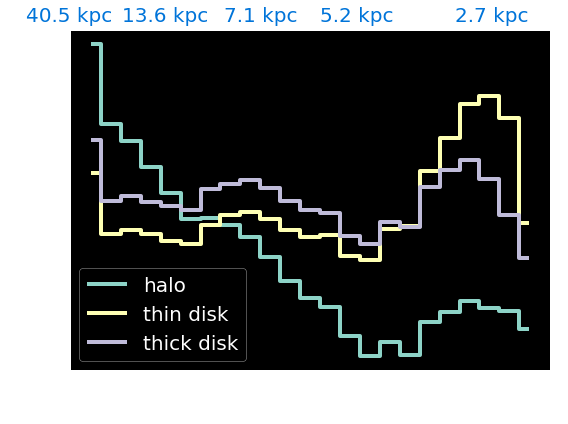

In [24]:
fig, ax=plt.subplots(figsize=(8, 6))
plt.step(np.arange(17, 40), halo_number['counts']*(1/400),\
         label='halo', where='mid')
plt.step(np.arange(17, 40), thin_number['counts'], \
         label='thin disk', where='mid')
plt.step(np.arange(17, 40), thick_number['counts']*(0.12), \
         label='thick disk', where='mid')


ax.set(xlabel='Spectral Type', \
       ylabel='Number/SpT', xticks=[17, 20, 25, 30, 35, 40],
      xticklabels=['M7', 'L0', 'L5', 'T0', 'T5','Y0'], yscale='log')

ax.grid(False, which='both', axis='x')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.array([15, 20, 25, 30, 37])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations, ave_limits ))
ax2.tick_params(colors='#0074D9', which='both') 
ax.legend()
plt.tight_layout()
ax.grid(False)
ax2.grid(False)
plt.savefig(popsims.FIGURES+'/jswt_counts.jpeg', dpi=600)

In [25]:
np.nansum(halo_number['counts']*(1/400))

3008.356504075242

In [26]:
np.nansum(thin_number['counts'])

3887.112184157063

In [27]:
np.nansum(thick_number['counts']*(0.12))

3636.997021921437

In [28]:
hn

NameError: name 'hn' is not defined

In [ ]:
p2=popsims.Pointing(coord=POINTS['wfirst'])
p2.mag_limits=grism_cuts['PRS']
wpave_limits=get_average_distance_limits(p2, grism_cuts['PRS'], survey='PRS')

In [ ]:
wthin_number=get_numbers(POINTS['jswt'], FOV['PRS'], grism_cuts['PRS'],\
                        
                        thin_disk, spgrid=np.arange(17, 40), survey='PRS')
wthick_number=get_numbers(POINTS['jswt'], FOV['PRS'], grism_cuts['PRS'],\
                        
                        thick_disk, h=900, spgrid=np.arange(17, 40), survey='PRS')
whalo_number=get_numbers(POINTS['jswt'], FOV['PRS'], grism_cuts['PRS'],\
                        
                        halo, spgrid=np.arange(17, 40), kind='halo', survey='PRS')

In [ ]:

p3=popsims.Pointing(coord=POINTS['wfirst'])
p3.mag_limits=grism_cuts['WFIRST_WIDE']
wide_ave_limits=get_average_distance_limits(p3, grism_cuts['WFIRST_WIDE'], survey='WFIRST_WIDE')

In [ ]:
wide_thin_number=get_numbers(POINTS['jswt'], FOV['WFIRST_WIDE'], grism_cuts['WFIRST_WIDE'],\
                        
                        thin_disk, spgrid=np.arange(17, 40), survey='WFIRST_WIDE')
wide_thick_number=get_numbers(POINTS['jswt'], FOV['WFIRST_WIDE'], grism_cuts['WFIRST_WIDE'],\
                        
                        thick_disk, h=900, spgrid=np.arange(17, 40), survey='WFIRST_WIDE')
wide_halo_number=get_numbers(POINTS['jswt'], FOV['WFIRST_WIDE'], grism_cuts['WFIRST_WIDE'],\
                        
                        halo, h=900, spgrid=np.arange(17, 40), kind='halo', survey='WFIRST_WIDE')

In [ ]:
fig, ax=plt.subplots(figsize=(8, 6))
plt.step(np.arange(17, 40), whalo_number['counts']*(1/400),\
         label='halo', where='mid')
plt.step(np.arange(17, 40), wthin_number['counts'], \
         label='thin disk', where='mid')
plt.step(np.arange(17, 40), wthick_number['counts']*(0.12), \
         label='thick disk', where='mid')
ax.set(xlabel='Spectral Type', \
       ylabel='Number/SpT/Pointing', xticks=[17, 20, 25, 30, 35, 40],
      xticklabels=['M7', 'L0', 'L5', 'T0', 'T5','Y0'], yscale='log')
ax.grid(False, which='both', axis='x')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.array([15, 20, 25, 30, 37])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations, wpave_limits ))
ax2.tick_params(colors='#0074D9', which='both') 
ax.legend()
plt.tight_layout()
ax.grid(False)
ax2.grid(False)
plt.savefig(popsims.FIGURES+'/wfirt_counts_spec.jpeg', dpi=600)

In [ ]:
FOV['WFIRST_WIDE'].to(u.radian**2), FOV['jswt'].to(u.radian**2)

In [ ]:
np.nansum( wide_halo_number['counts']*(1/400)),
np.nansum(wide_thick_number['counts']*(0.12))

In [ ]:
fig, ax=plt.subplots(figsize=(8, 6))
plt.step(np.arange(17, 40), wide_halo_number['counts']*(1/400),\
         label='halo', where='mid')
plt.step(np.arange(17, 40), wide_thin_number['counts'], \
         label='thin disk', where='mid')
plt.step(np.arange(17, 40), wide_thick_number['counts']*(0.12), \
         label='thick disk', where='mid')
ax.set(xlabel='Spectral Type', \
       ylabel='Number/SpT', xticks=[17, 20, 25, 30, 35, 40],
      xticklabels=['M7', 'L0', 'L5', 'T0', 'T5','Y0'],
      yscale='log')
ax.grid(False, which='both', axis='x')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.array([15, 20, 25, 30, 37])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations, wide_ave_limits ))
ax2.tick_params(colors='#0074D9', which='both') 
ax.legend()
plt.tight_layout()
ax.grid(False)
ax2.grid(False)
plt.savefig(popsims.FIGURES+'/wfirt_counts_wide.jpeg', dpi=600)

In [ ]:
p5=popsims.Pointing(coord=POINTS['euclid'])
p5.mag_limits=grism_cuts['EUCLID']
eude_ave_limits=get_average_distance_limits(p5, grism_cuts['EUCLID'], survey='EUCLID')
eu_thin_number=get_numbers(POINTS['jswt'], FOV['EUCLID'], grism_cuts['EUCLID'],\
                        
                        thin_disk, spgrid=np.arange(17, 40), survey='EUCLID')
eu_thick_number=get_numbers(POINTS['jswt'], FOV['EUCLID'], grism_cuts['EUCLID'],\
                        
                        thick_disk, h=900, spgrid=np.arange(17, 40), survey='EUCLID')
eu_halo_number=get_numbers(POINTS['jswt'], FOV['EUCLID'], grism_cuts['EUCLID'],\
                        
                        halo, spgrid=np.arange(17, 40), kind='halo', survey='EUCLID')

In [ ]:
np.nansum(eu_halo_number['counts']*(1/400)),  np.nansum(eu_thick_number['counts']*(0.12))


In [ ]:
220*(u.arcmin**2).to(u.deg**2)*124

In [ ]:
fig, ax=plt.subplots(figsize=(8, 6))
plt.step(np.arange(17, 40), eu_halo_number['counts']*(1/400),\
         label='halo', where='mid')
plt.step(np.arange(17, 40), eu_thin_number['counts'], \
         label='thin disk', where='mid')
plt.step(np.arange(17, 40), eu_thick_number['counts']*(0.12), \
         label='thick disk', where='mid')
ax.set(xlabel='Spectral Type', \
       ylabel='Number/SpT', xticks=[17, 20, 25, 30, 35, 40],
      xticklabels=['M7', 'L0', 'L5', 'T0', 'T5','Y0'],
      yscale='log')
ax.grid(False, which='both', axis='x')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.array([15, 20, 25, 30, 37])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations,eude_ave_limits ))
ax2.tick_params(colors='#0074D9', which='both') 
ax.legend()
ax.grid(False)
ax2.grid(False)
plt.tight_layout()
plt.savefig(popsims.FIGURES+'/euclid_counts_wide.jpeg', dpi=600)

In [ ]:
#diagnostics
disk_vol=[popsims.volume_calc(p.coord.galactic.l.radian,\
                                   p.coord.galactic.b.radian,
                                   1., x, 350, kind='exp') for x in np.logspace(1, 4, 100)]
tdisk_vol=[popsims.volume_calc(p.coord.galactic.l.radian,\
                                   p.coord.galactic.b.radian,
                                   1., x, 900, kind='exp') for x in np.logspace(1, 4, 100)]
halo_vol=[popsims.volume_calc(p.coord.galactic.l.radian,\
                                   p.coord.galactic.b.radian,
                                   1., x, 900, kind='spheroid') for x in np.logspace(1, 4, 100)]

In [ ]:
fig, ax=plt.subplots()
plt.plot(np.logspace(1, 4, 100), disk_vol, label='thin disk')
plt.plot(np.logspace(1, 4, 100), np.array(tdisk_vol)*0.12, label='thick disk')
plt.plot(np.logspace(1, 4, 100), np.array(halo_vol)/400, label='halo')
plt.legend()
ax.grid(False)
#ax.set(xscale='log', yscale='log')

In [ ]:
popsims.DATA_FOLDER